Name: Eddie Ekpoh

Project Summary: Cleaning dataframe and making visualizations about data from the National Snow and Ice Data Center (NSIDC) and Japan's
version, the Arctic Data Archive System (ADS).

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

Reading CSV file and converting it into a pandas series

In [3]:
fname = 'N_seaice_extent_daily_v3.0.csv'
df = pd.read_csv(fname, skiprows=2, names=[0, 1, 2, 'Extent'], 
usecols=[0, 1, 2, 3], parse_dates={'Dates': [0, 1, 2]}, header=None)
df

,Dates,Extent
0,1978-10-26,10.231
1,1978-10-28,10.420
2,1978-10-30,10.557
3,1978-11-01,10.670
4,1978-11-03,10.777
...,...,...
14363,2022-08-30,5.242
14364,2022-08-31,5.159
14365,2022-09-01,5.026
14366,2022-09-02,4.986


In [4]:
series = pd.Series(df['Extent'].values, df['Dates'].values)
dates = pd.date_range('1978-10-26', '2022-09-03')
series = series.reindex(dates)
series

1978-10-26    10.231
1978-10-27       NaN
1978-10-28    10.420
1978-10-29       NaN
1978-10-30    10.557
               ...  
2022-08-30     5.242
2022-08-31     5.159
2022-09-01     5.026
2022-09-02     4.986
2022-09-03     4.986
Freq: D, Length: 16019, dtype: float64

Filling NA values of series by replacing them with means of previous and
next values or the means of the previous years if the NA values are consecutive

In [5]:
for i in range(len(series.index)):
  if pd.isnull(series.iloc[i]):
    series.iloc[i] = (series.iloc[i-1] + series.iloc[i+1]) / 2
for date in range(len(series)):
  if pd.isnull(series[date]):
    series[date] = (series[date-365] + series[date+366]) / 2

In [6]:
series

1978-10-26    10.2310
1978-10-27    10.3255
1978-10-28    10.4200
1978-10-29    10.4885
1978-10-30    10.5570
               ...   
2022-08-30     5.2420
2022-08-31     5.1590
2022-09-01     5.0260
2022-09-02     4.9860
2022-09-03     4.9860
Freq: D, Length: 16019, dtype: float64

Creating new column labels for dataframes (mmdd)

In [7]:
column_labels= []
dates = pd.date_range('1978-01-01', '1978-12-31')
for date in dates:
  date = str(date)
  date = date[0:10] #eliminates minutes and seconds
  date = date.replace('-', '') 
  column_labels.append(date[4:])

Creating 1979-2021 dataframe with mmdd labels as the columns and years as the rows. Filling values from the series.

In [8]:
data_79_21 = pd.DataFrame(index=range(1979, 2022), columns=column_labels, dtype=np.float64)
for row in data_79_21.index:
  for col in data_79_21.columns:
    data_79_21.loc[row, col] = series.loc[datetime(row, int(col[:2]), int(col[2:]))]
data_79_21.head()

,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
1979,14.7910,14.9970,14.9595,14.9220,14.9255,14.9290,14.9485,14.968,15.0790,15.1900,...,13.6190,13.6960,13.7730,13.8535,13.9340,14.0175,14.1010,14.0965,14.092,14.1460
1980,14.2000,14.2510,14.3020,14.3580,14.4140,14.4660,14.5180,14.556,14.5940,14.6295,...,13.7790,13.7885,13.7980,13.8990,14.0000,14.0860,14.1720,14.1325,14.093,14.1745
1981,14.2560,14.3560,14.4560,14.4455,14.4350,14.5620,14.6890,14.654,14.6190,14.6545,...,13.8850,13.8770,13.9465,14.0160,13.9845,13.9530,14.0405,14.1280,14.176,14.2240
1982,14.3515,14.4790,14.5605,14.6420,14.7610,14.8800,14.9365,14.993,15.0225,15.0520,...,13.9630,14.0280,14.0930,14.1380,14.1830,14.1635,14.1440,14.1515,14.159,14.2060
1983,14.2530,14.2795,14.3060,14.4000,14.4940,14.4805,14.4670,14.541,14.6150,14.6315,...,13.4325,13.5390,13.5395,13.5400,13.6020,13.6640,13.7595,13.8550,13.881,13.9070


Extracting information from only the year of 2022

In [9]:
data_2022 = series.loc['2022-1-1':]
data_2022

2022-01-01    13.302
2022-01-02    13.438
2022-01-03    13.411
2022-01-04    13.436
2022-01-05    13.477
               ...  
2022-08-30     5.242
2022-08-31     5.159
2022-09-01     5.026
2022-09-02     4.986
2022-09-03     4.986
Freq: D, Length: 246, dtype: float64

Turning the two pandas dataframes into CSV files

In [10]:
data_79_21.to_csv('data_79_21.csv')
data_2022.to_csv('data_2022.csv')

New dataframe that has the mean and 2 + standard deviation of the 1979-2021 dataframe

In [11]:
fig1frame= pd.DataFrame(index=['mean', 'two_s'], columns=column_labels)
for row in fig1frame.index:
  for col in fig1frame.columns:
    if row == 'mean':
      fig1frame.loc[row, col] = data_79_21[col].mean()
    if row == 'two_s':
      fig1frame.loc[row, col] = 2 * data_79_21[col].std()


In [12]:
fig1frame

,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
mean,13.595895,13.65843,13.700186,13.744791,13.787779,13.830477,13.886297,13.920081,13.9675,14.002081,...,13.036959,13.090953,13.151994,13.197035,13.234901,13.27043,13.318953,13.367884,13.413052,13.453698
two_s,1.146975,1.197419,1.21062,1.182193,1.174271,1.195271,1.200398,1.236719,1.234294,1.234063,...,1.155156,1.18955,1.157499,1.152183,1.152483,1.111295,1.104492,1.094449,1.090874,1.10604


Another frame that holds the means of each decade from the 80s to the 2010s

In [13]:
fig2frame = pd.DataFrame(index=['1980s', '1990s', '2000s', '2010s'], columns=column_labels)
eighties = data_79_21.loc[1980:1989].mean()
nineties = data_79_21.loc[1990:1999].mean()
thousands = data_79_21.loc[2000:2009].mean()
tens = data_79_21.loc[2010:2019].mean()
fig2frame.loc['1980s'] = eighties
fig2frame.loc['1980s'] = eighties
fig2frame.loc['1990s'] = nineties
fig2frame.loc['2000s'] = thousands
fig2frame.loc['2010s'] = tens 

In [14]:
fig2frame

,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
1980s,14.17055,14.26045,14.33735,14.3964,14.4436,14.48785,14.537725,14.59135,14.63535,14.66915,...,13.668825,13.7397,13.771175,13.807,13.843675,13.8515,13.8945,13.93445,13.984325,14.0718
1990s,13.9606,14.0418,14.0667,14.0807,14.1123,14.1782,14.2436,14.2888,14.3284,14.3389,...,13.4097,13.4729,13.5275,13.5893,13.625,13.6322,13.6693,13.7247,13.7758,13.7829
2000s,13.3485,13.3712,13.4223,13.4738,13.5293,13.5606,13.6357,13.6663,13.7003,13.7361,...,12.7912,12.8452,12.9113,12.9337,12.9864,13.0495,13.1012,13.1407,13.1793,13.2192
2010s,12.9279,12.9799,12.9916,13.0568,13.1069,13.1403,13.1766,13.1797,13.2557,13.3063,...,12.3105,12.3408,12.4335,12.4947,12.5251,12.575,12.6406,12.7126,12.7563,12.7819


In [15]:
fig2frame

,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
1980s,14.17055,14.26045,14.33735,14.3964,14.4436,14.48785,14.537725,14.59135,14.63535,14.66915,...,13.668825,13.7397,13.771175,13.807,13.843675,13.8515,13.8945,13.93445,13.984325,14.0718
1990s,13.9606,14.0418,14.0667,14.0807,14.1123,14.1782,14.2436,14.2888,14.3284,14.3389,...,13.4097,13.4729,13.5275,13.5893,13.625,13.6322,13.6693,13.7247,13.7758,13.7829
2000s,13.3485,13.3712,13.4223,13.4738,13.5293,13.5606,13.6357,13.6663,13.7003,13.7361,...,12.7912,12.8452,12.9113,12.9337,12.9864,13.0495,13.1012,13.1407,13.1793,13.2192
2010s,12.9279,12.9799,12.9916,13.0568,13.1069,13.1403,13.1766,13.1797,13.2557,13.3063,...,12.3105,12.3408,12.4335,12.4947,12.5251,12.575,12.6406,12.7126,12.7563,12.7819


Switiching the 2022 series' index to mmdd values that represent the days within the 2022 year

In [16]:
column_labels = column_labels[:246]
data_2022.index = column_labels
data_2022

0101    13.302
0102    13.438
0103    13.411
0104    13.436
0105    13.477
         ...  
0830     5.242
0831     5.159
0901     5.026
0902     4.986
0903     4.986
Length: 246, dtype: float64

Creating first visualization

- Plots the 2022 series along with the 2012 column in the 1979-2021 dataframe
- Plots the overall mean of the 1979-2021 dataframe
- Plots the standard deviation of the frame, which represents the potential range of values of the dataframe

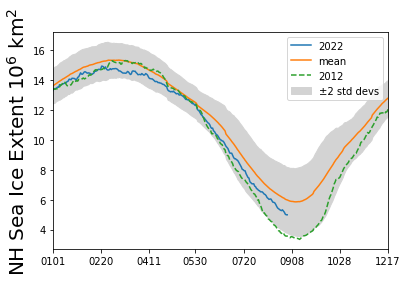

In [17]:
plt.ylabel('NH Sea Ice Extent 10$^{6}$ km$^{2}$', fontsize=20)
ticks = ['0101', '0220', '0411', '0530', '0720', '0908', '1028', '1217']
plt.plot(data_2022, label='2022')
plt.plot(fig1frame.loc['mean'], label='mean')
plt.plot(data_79_21.loc[2012], linestyle = '--', label='2012')
plt.fill_between(data_79_21.columns, fig1frame.loc['mean'].values.astype(float) + fig1frame.loc['two_s'].values.astype(float),
  fig1frame.loc['mean'].values.astype(float) - fig1frame.loc['two_s'].values.astype(float), 
  color='lightgray', label = '±2 std devs')
plt.xlim('0101', '1217')
plt.xticks(ticks, labels = ticks)
plt.legend(loc='upper right')
plt.show()

- Plots the columns in the fig2frame, which holds the means of each decade from 1979-2021
- Also plots the extent values of 2022

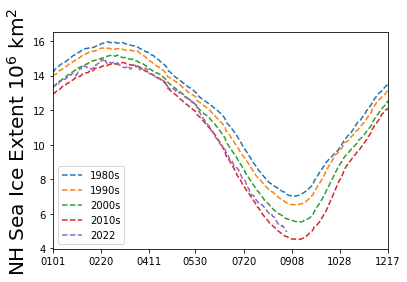

In [18]:
plt.ylabel('NH Sea Ice Extent 10$^{6}$ km$^{2}$', fontsize=20)
plt.plot(fig2frame.loc['1980s'], linestyle='--', label='1980s')
plt.plot(fig2frame.loc['1990s'], linestyle='--', label='1990s')
plt.plot(fig2frame.loc['2000s'], linestyle='--', label='2000s')
plt.plot(fig2frame.loc['2010s'], linestyle='--', label='2010s')
plt.plot(data_2022, linestyle='--', label='2022')
plt.xlim('0101', '1217')
plt.legend(loc='lower left')
plt.xticks(['0101', '0220', '0411', '0530', '0720', '0908', '1028', '1217'], 
labels= ['0101', '0220', '0411', '0530', '0720', '0908', '1028', '1217'])
plt.show()